# Modeling Human Activity States Using Hidden Markov Models

This notebook demonstrates a complete implementation of Hidden Markov Models (HMM) for human activity recognition using accelerometer and gyroscope sensor data.

## Project Overview

We will:
1. Generate synthetic sensor data mimicking real smartphone sensors
2. Extract time-domain and frequency-domain features
3. Implement and train an HMM model
4. Evaluate the model performance
5. Visualize results and analyze findings

**Activities to classify:**
- Standing
- Walking  
- Jumping
- Still (no movement)

## 1. Setup and Imports

In [13]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from scipy.fft import fft, fftfreq
import warnings
import os
import glob
from sklearn.preprocessing import StandardScaler
from scipy.special import logsumexp
from sklearn.cluster import KMeans  # For better init
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Define activities
activities = ['standing', 'walking', 'jumping', 'still']
n_states = len(activities)
state_to_idx = {act: idx for idx, act in enumerate(activities)}
activity_to_state = {idx: act for act, idx in state_to_idx.items()}

print("Setup complete!")

Setup complete!


## 2. Data Collection and Generation

Since we're demonstrating the methodology, we'll generate synthetic sensor data that mimics real accelerometer and gyroscope readings from smartphone sensors.

**Note:** In a real implementation, you would use the Sensor Logger app or similar to collect actual sensor data.

In [14]:
import pandas as pd
import numpy as np
import glob
import os

def load_sample_from_subfolder(subfolder_path, activity_name, sample_num):
    """
    Load one sample subfolder (e.g., amandine_jumping1/): Merge accel + gyro on 'seconds_elapsed'.
    - Accel: Accelerometer.csv (cols: 'seconds_elapsed', 'z/y/x' → accel_z/y/x)
    - Gyro: Gyroscope.csv (similar → gyro_z/y/x)
    - Metadata: For fs
    - Ignores Uncalibrated/Annotation.
    """
    sample_id = f"{activity_name}_{sample_num:02d}"
    print(f"Loading subfolder {os.path.basename(subfolder_path)} as {sample_id}")
    
    # Load accel
    accel_file = os.path.join(subfolder_path, 'Accelerometer.csv')
    if not os.path.exists(accel_file):
        print(f"No Accelerometer.csv in {subfolder_path}")
        return pd.DataFrame()
    accel_df = pd.read_csv(accel_file)
    accel_df = accel_df.rename(columns={'z': 'accel_z', 'y': 'accel_y', 'x': 'accel_x'})
    accel_df = accel_df[['seconds_elapsed', 'accel_x', 'accel_y', 'accel_z']].dropna()
    
    # Load gyro
    gyro_file = os.path.join(subfolder_path, 'Gyroscope.csv')
    has_gyro = os.path.exists(gyro_file)
    if has_gyro:
        gyro_df = pd.read_csv(gyro_file)
        gyro_df = gyro_df.rename(columns={'z': 'gyro_z', 'y': 'gyro_y', 'x': 'gyro_x'})
        gyro_df = gyro_df[['seconds_elapsed', 'gyro_x', 'gyro_y', 'gyro_z']].dropna()
        # Merge on seconds_elapsed (inner: common timestamps)
        df = pd.merge(accel_df, gyro_df, on='seconds_elapsed', how='inner')
        print(f"Merged accel+gyro: {len(df)} rows (from accel {len(accel_df)}, gyro {len(gyro_df)})")
    else:
        df = accel_df
        print(f"No Gyroscope.csv—accel-only: {len(df)} rows")
    
    if len(df) < 2:
        print(f"Skipping {sample_id}: too few rows after merge/cleaning.")
        return pd.DataFrame()
    
    # Add labels
    df['activity'] = activity_name
    df['sample_id'] = sample_id
    
    # Metadata fs
    metadata_file = os.path.join(subfolder_path, 'Metadata.csv')
    fs_meta = None
    if os.path.exists(metadata_file):
        try:
            meta_df = pd.read_csv(metadata_file)
            if not meta_df.empty:
                # Assume key-value cols (e.g., col0='sampling_rate', col1=99)
                for _, row in meta_df.iterrows():
                    key = str(row.iloc[0]).strip().lower()
                    if 'sampling_rate' in key:
                        fs_meta = float(row.iloc[1])
                        break
                if fs_meta:
                    print(f"Using fs from metadata: {fs_meta} Hz")
                    df['fs'] = fs_meta
                    return df, fs_meta
        except Exception as e:
            print(f"Metadata error: {e}")
    
    # Compute fs
    time_diffs = np.diff(df['seconds_elapsed'].values)
    valid_diffs = time_diffs[~np.isnan(time_diffs)]
    if len(valid_diffs) > 0:
        fs_computed = 1 / np.mean(valid_diffs)
        df['fs'] = fs_computed
        print(f"Computed fs: {fs_computed:.1f} Hz")
        return df, fs_computed
    else:
        fs_default = 99.0  # From prior
        df['fs'] = fs_default
        print(f"No valid diffs—default fs={fs_default} Hz")
        return df, fs_default

# ... (load_sample_from_subfolder unchanged from last—dup-safe)

def load_sensor_from_folder(folder_path, activity_name):
    """Load all subfolders."""
    data_dfs = []
    sample_count = 0
    
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    print(f"Found {len(subfolders)} subfolders in {folder_path}")
    
    for subfolder in subfolders:
        df, this_fs = load_sample_from_subfolder(subfolder, activity_name, sample_count + 1)
        if not df.empty:
            data_dfs.append(df)
            print(f"Added sample to {activity_name}: {len(df)} rows")
        sample_count += 1
    
    if not data_dfs:
        print(f"No data for {activity_name}")
        return pd.DataFrame(), 99.6
    
    # Concat per activity (debug)
    activity_dataset = pd.concat(data_dfs, ignore_index=True)
    activity_dataset = activity_dataset.astype({'seconds_elapsed': 'float64'})  # Dtype fix
    print(f"Per-activity concat: {len(activity_dataset)} rows")
    
    overall_fs = activity_dataset['fs'].median() if 'fs' in activity_dataset.columns else 99.6
    has_gyro = 'gyro_x' in activity_dataset.columns
    print(f"{activity_name}: Gyro={has_gyro}, {len(activity_dataset)} rows, fs={overall_fs:.1f} Hz")
    return activity_dataset, overall_fs

# Main load loop (debug all_datasets)
activity_folders = {
    'standing': '../data/standing/',
    'walking': '../data/walking/',
    'jumping': '../data/jumping/',
    'still': '../data/still/'
}

all_datasets = {}
fs = None
for act, folder in activity_folders.items():
    if os.path.exists(folder):
        data, this_fs = load_sensor_from_folder(folder, act)
        if not data.empty:
            all_datasets[act] = data
            print(f"Stored {act} in all_datasets: {len(data)} rows")
            if fs is None:
                fs = this_fs
            else:
                fs = (fs + this_fs) / 2
    else:
        print(f"Folder {folder} not found")

print(f"\nall_datasets keys/lens: {[(k, len(v)) for k, v in all_datasets.items()]}")

# Combine (robust concat)
if all_datasets:
    dataset_list = list(all_datasets.values())
    dataset = pd.concat(dataset_list, ignore_index=True)
    dataset = dataset.astype({'seconds_elapsed': 'float64', 'accel_x': 'float64', 'accel_y': 'float64', 'accel_z': 'float64'})
    if 'gyro_x' in dataset.columns:
        dataset = dataset.astype({'gyro_x': 'float64', 'gyro_y': 'float64', 'gyro_z': 'float64'})
    print(f"Global concat: {len(dataset)} rows")
else:
    dataset = pd.DataFrame()
    print("No data—check folders/files.")

print(f"Overall dataset shape: {dataset.shape}")
print(f"Columns: {list(dataset.columns)}")
if not dataset.empty and 'activity' in dataset.columns:
    print(f"Activity dist:\n{dataset['activity'].value_counts()}")
print(f"Harmonized fs: {fs:.1f} Hz")
print(f"Gyro present overall: {'gyro_x' in dataset.columns}")

# Save
if not dataset.empty:
    dataset.to_csv('combined_sensor_data.csv', index=False)
    print("Saved combined_sensor_data.csv")

Found 12 subfolders in ../data/standing/
Loading subfolder amandine_standing_1 as standing_01
Merged accel+gyro: 843 rows (from accel 843, gyro 843)
Computed fs: 99.6 Hz
Added sample to standing: 843 rows
Loading subfolder amandine_standing_2 as standing_02
Merged accel+gyro: 853 rows (from accel 853, gyro 853)
Computed fs: 99.6 Hz
Added sample to standing: 853 rows
Loading subfolder amandine_standing_3 as standing_03
Merged accel+gyro: 815 rows (from accel 815, gyro 815)
Computed fs: 99.6 Hz
Added sample to standing: 815 rows
Loading subfolder amandine_standing_4 as standing_04
Merged accel+gyro: 807 rows (from accel 807, gyro 807)
Computed fs: 99.6 Hz
Added sample to standing: 807 rows
Loading subfolder amandine_standing_5 as standing_05
Merged accel+gyro: 854 rows (from accel 854, gyro 854)
Computed fs: 99.6 Hz
Added sample to standing: 854 rows
Loading subfolder amandine_standing_6 as standing_06
Merged accel+gyro: 820 rows (from accel 820, gyro 820)
Computed fs: 99.6 Hz
Added samp

### Visualize Sample Sensor Data

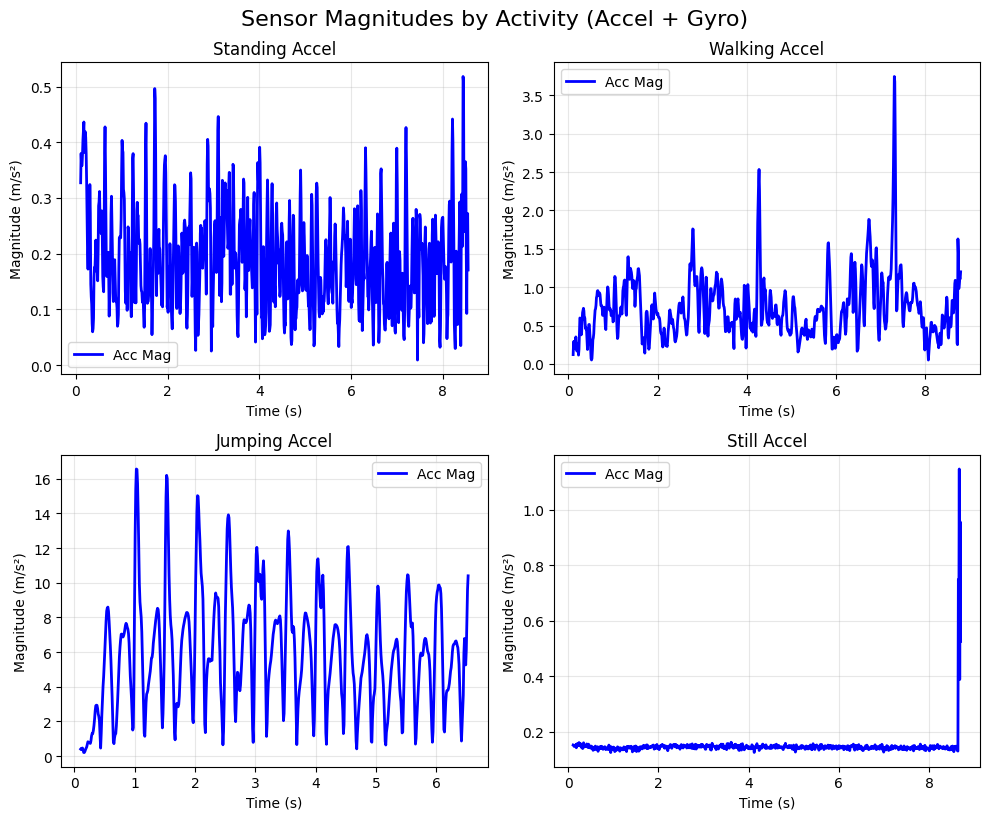

In [15]:
# Visualize first sample per activity (accel + gyro mag, no blank subplots, no 'return')
if dataset.empty:
    print("No data to visualize.")
else:
    # Count activities with data
    active_acts = [act for act in activities if not dataset[dataset['activity'] == act].empty]
    n_acts = len(active_acts)
    if n_acts == 0:
        print("No activities with data to visualize.")
    else:
        # Grid: 1 row for accel, +1 for gyro if present
        has_gyro = 'gyro_x' in dataset.columns
        n_rows = 2 if has_gyro else 1
        n_cols = max(2, (n_acts + n_rows - 1) // n_rows)  # Min 2 cols for balance
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
        
        # Plot per active activity
        for idx, act in enumerate(active_acts):
            ax_idx = idx  # Simple sequential
            sample_data = dataset[dataset['activity'] == act]
            sample_data = sample_data[sample_data['sample_id'] == sample_data['sample_id'].iloc[0]]
            time_seconds = sample_data['seconds_elapsed'].values
            
            # Accel mag
            acc_magnitude = np.sqrt(sample_data['accel_x']**2 + sample_data['accel_y']**2 + sample_data['accel_z']**2)
            axes[ax_idx].plot(time_seconds, acc_magnitude, label='Acc Mag', linewidth=2, color='blue')
            axes[ax_idx].set_title(f'{act.title()} Accel')
            axes[ax_idx].set_xlabel('Time (s)')
            axes[ax_idx].set_ylabel('Magnitude (m/s²)')
            axes[ax_idx].legend()
            axes[ax_idx].grid(True, alpha=0.3)
            
            # Gyro mag (next ax if present)
            if has_gyro:
                gyro_ax_idx = ax_idx + n_acts  # Second row start
                if gyro_ax_idx < len(axes):
                    gyro_magnitude = np.sqrt(sample_data['gyro_x']**2 + sample_data['gyro_y']**2 + sample_data['gyro_z']**2)
                    axes[gyro_ax_idx].plot(time_seconds, gyro_magnitude, label='Gyro Mag', linewidth=2, color='red')
                    axes[gyro_ax_idx].set_title(f'{act.title()} Gyro')
                    axes[gyro_ax_idx].set_xlabel('Time (s)')
                    axes[gyro_ax_idx].set_ylabel('Magnitude (rad/s)')
                    axes[gyro_ax_idx].legend()
                    axes[gyro_ax_idx].grid(True, alpha=0.3)
        
        # Hide extra axes
        for i in range(len(active_acts) + (n_acts if has_gyro else 0), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        title = 'Sensor Magnitudes by Activity (Accel + Gyro)' if has_gyro else 'Accel Magnitude by Activity'
        plt.suptitle(title, y=1.02, fontsize=16)
        plt.savefig('raw_sensor_viz.png', dpi=300, bbox_inches='tight')  # For report
        plt.show()

## 3. Feature Extraction

We extract both time-domain and frequency-domain features from sliding windows of sensor data.

In [16]:
def extract_time_features(window):
    """Time-domain: mean, std, SMA for accel."""
    accel = window[['accel_x', 'accel_y', 'accel_z']].values
    means = np.mean(accel, axis=0)
    stds = np.std(accel, axis=0)
    mag = np.sqrt(np.sum(accel**2, axis=1))
    sma = np.sum(mag)
    return np.concatenate([means, stds, [sma]])

def extract_freq_features(window, fs):
    """Frequency-domain: dominant freq, spectral energy from mag FFT."""
    mag = np.sqrt(np.sum(window[['accel_x', 'accel_y', 'accel_z']]**2, axis=1))
    N = len(mag)
    yf = fft(mag)
    xf = fftfreq(N, 1/fs)[:N//2]
    power = 2.0/N * np.abs(yf[:N//2])**2
    dominant_freq = xf[np.argmax(power)]
    spectral_energy = np.sum(power)
    return np.array([dominant_freq, spectral_energy])

def extract_features_from_dataset(dataset, window_size_sec=1.0, overlap=0.5, fs=100.0):
    """Extract features with overlap, include labels. Uses provided fs. Reduced default window to 1s."""
    if dataset.empty:
        print("Empty dataset - no features extracted.")
        return pd.DataFrame()
    
    window_size = max(int(window_size_sec * fs), 10)  # Min 10 samples
    step_size = max(int(window_size * (1 - overlap)), 1)
    features = []
    labels = []
    sample_ids = []
    window_idxs = []
    
    print(f"Debug: Dataset length: {len(dataset)}, window_size: {window_size}, step_size: {step_size}")
    
    for sample_id, group in dataset.groupby('sample_id'):
        group_len = len(group)
        sample_fs = group['fs'].iloc[0] if 'fs' in group.columns else fs
        print(f"Debug: Sample {sample_id} length: {group_len}, fs: {sample_fs:.1f}")
        if group_len < window_size:
            print(f"Warning: Sample {sample_id} too short ({group_len} < {window_size}) - skipping.")
            continue
        for i in range(0, group_len - window_size + 1, step_size):
            window = group.iloc[i:i+window_size]
            if len(window) == window_size:
                time_feats = extract_time_features(window)
                freq_feats = extract_freq_features(window, sample_fs)
                feat_vec = np.concatenate([time_feats, freq_feats])
                features.append(feat_vec)
                labels.append(state_to_idx[group['activity'].iloc[0]])
                sample_ids.append(sample_id)
                window_idxs.append(i // step_size)
            else:
                print(f"Warning: Incomplete window at i={i} for {sample_id}")
    
    if not features:
        print("No valid windows - try reducing window_size_sec to 0.5.")
        return pd.DataFrame()
    
    feature_names = ([f'acc_x_{stat}' for stat in ['mean', 'std']] + 
                     [f'acc_y_{stat}' for stat in ['mean', 'std']] + 
                     [f'acc_z_{stat}' for stat in ['mean', 'std']] + ['acc_sma', 'dom_freq', 'spectral_energy'])
    features_df = pd.DataFrame(features, columns=feature_names)
    features_df['activity'] = [activity_to_state[l] for l in labels]
    features_df['sample_id'] = sample_ids
    features_df['window_idx'] = window_idxs
    return features_df

# Extract (use global fs, reduced window)
if 'fs' in locals() and not dataset.empty:
    window_size_sec = 1.0  # Reduced to 1s for short samples
    overlap = 0.5
    features_df = extract_features_from_dataset(dataset, window_size_sec, overlap, fs)
else:
    features_df = pd.DataFrame()

print(f"Features shape: {features_df.shape}")
if not features_df.empty and 'activity' in features_df.columns:
    print(f"Feature windows per activity:\n{features_df['activity'].value_counts()}")
else:
    print("No features or 'activity' column - skipping distribution.")
if features_df.shape[1] > 0:
    print(f"Feature names (first 10): {list(features_df.columns[:10])}")
else:
    print("No feature columns.")

# Save
if not features_df.empty:
    features_path = 'extracted_features.csv'
    features_df.to_csv(features_path, index=False)
    print(f"\nFeatures saved to {features_path}")
else:
    print("No features to save.")

Debug: Dataset length: 39434, window_size: 99, step_size: 49
Debug: Sample jumping_01 length: 641, fs: 99.6
Debug: Sample jumping_02 length: 619, fs: 99.6
Debug: Sample jumping_03 length: 612, fs: 99.6
Debug: Sample jumping_04 length: 596, fs: 99.6
Debug: Sample jumping_05 length: 619, fs: 99.6
Debug: Sample jumping_06 length: 605, fs: 99.6
Debug: Sample jumping_07 length: 636, fs: 99.6
Debug: Sample jumping_08 length: 596, fs: 99.6
Debug: Sample jumping_09 length: 624, fs: 99.6
Debug: Sample jumping_10 length: 670, fs: 99.6
Debug: Sample jumping_11 length: 628, fs: 99.6
Debug: Sample jumping_12 length: 655, fs: 99.6
Debug: Sample standing_01 length: 843, fs: 99.6
Debug: Sample standing_02 length: 853, fs: 99.6
Debug: Sample standing_03 length: 815, fs: 99.6
Debug: Sample standing_04 length: 807, fs: 99.6
Debug: Sample standing_05 length: 854, fs: 99.6
Debug: Sample standing_06 length: 820, fs: 99.6
Debug: Sample standing_07 length: 832, fs: 99.6
Debug: Sample standing_08 length: 818, 

### Visualize Feature Distributions

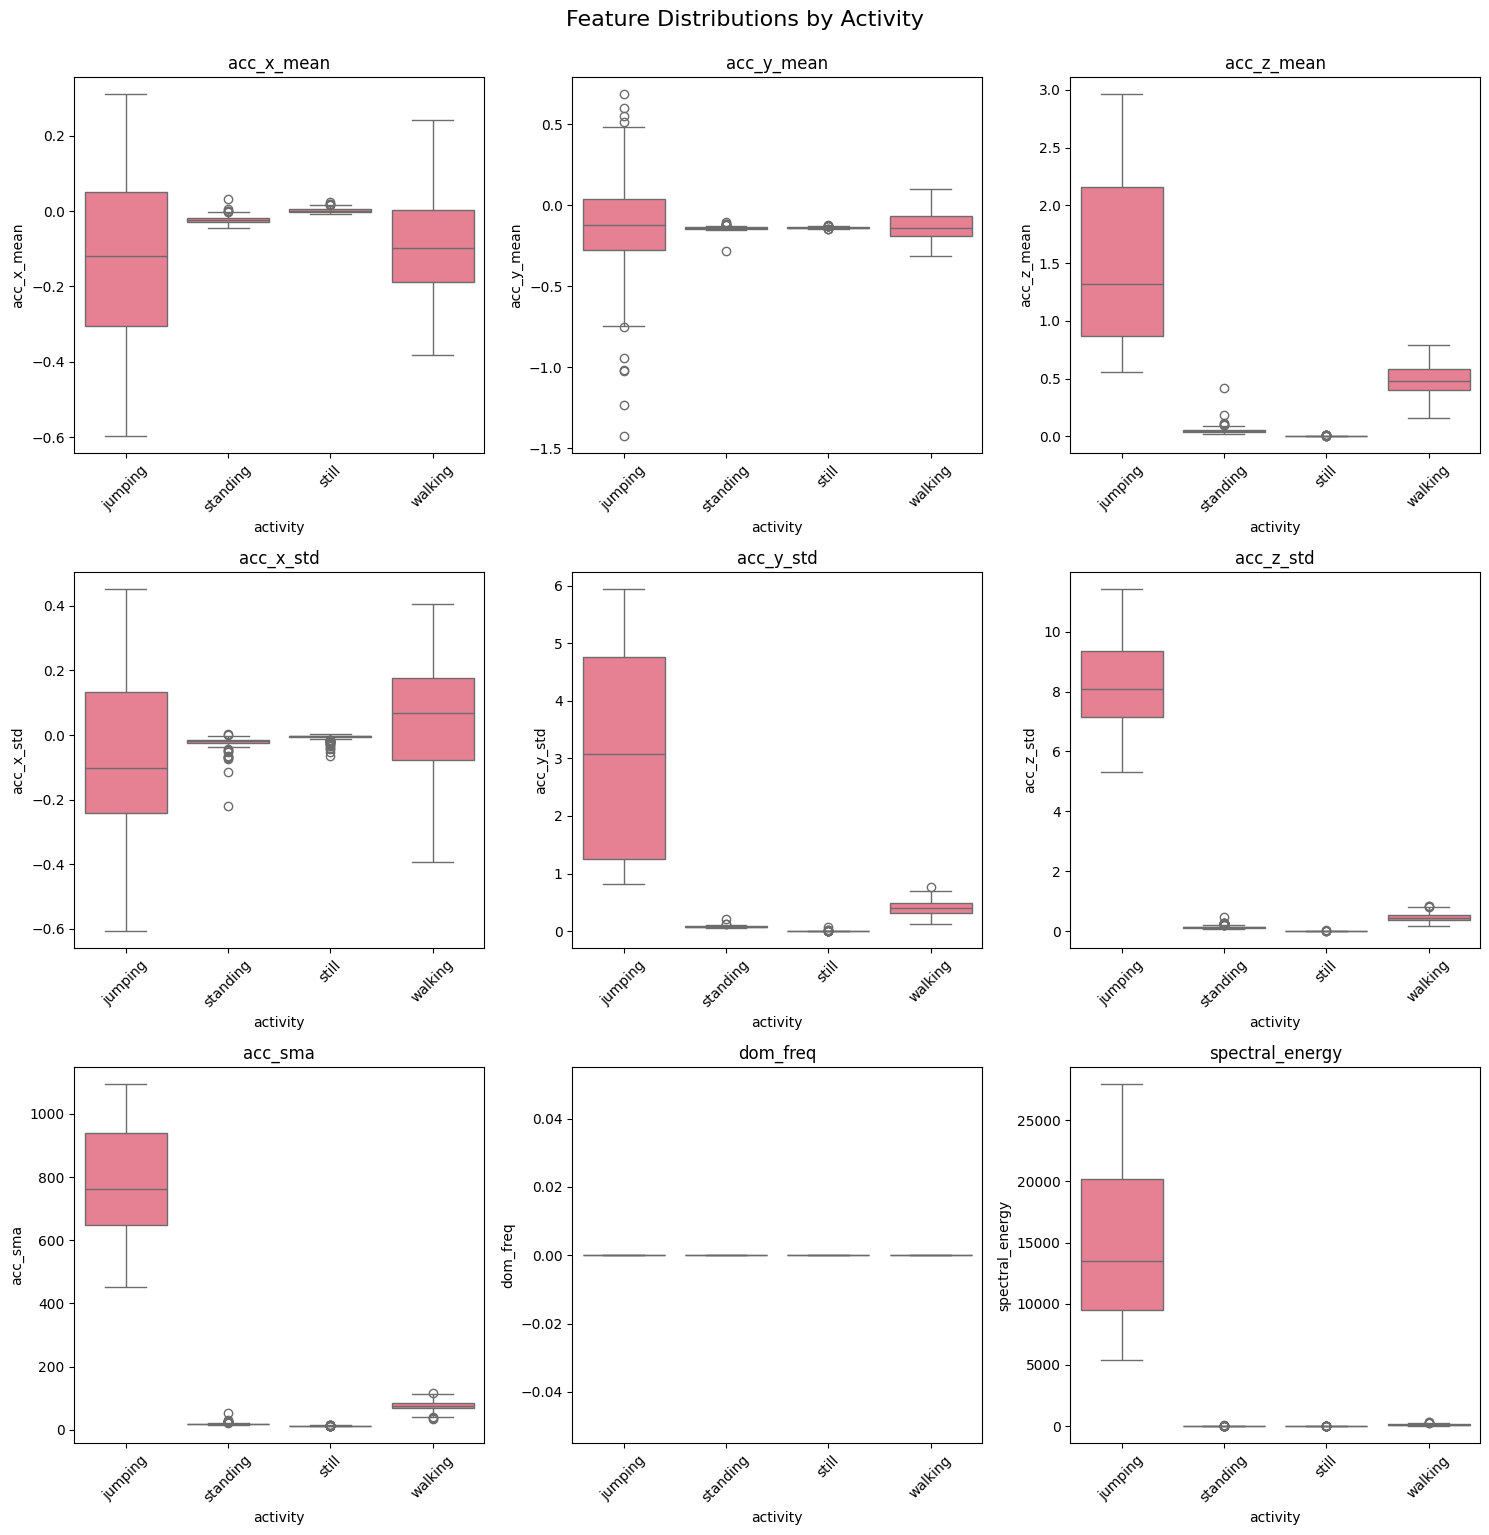

In [17]:
if not features_df.empty and len(features_df) > 0:
    # Select important features
    important_features = ['acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'acc_x_std', 'acc_y_std', 'acc_z_std', 'acc_sma', 'dom_freq', 'spectral_energy']

    n_features = len(important_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(important_features):
        if feature in features_df.columns:
            sns.boxplot(data=features_df, x='activity', y=feature, ax=axes[i])
            axes[i].set_title(f'{feature}')
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].set_visible(False)

    # Hide unused
    for i in range(len(important_features), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Feature Distributions by Activity', y=1.02, fontsize=16)
    plt.show()
else:
    print("No features to visualize.")

## 4. Data Splitting

Split the data into training and testing sets, ensuring we maintain sample-level separation.

In [18]:
if not features_df.empty:
    # Split by sample_id (no leakage)
    unique_samples = features_df['sample_id'].unique()
    print(f"Total unique samples: {len(unique_samples)}")

    # Balanced split per activity
    train_samples = []
    test_samples = []

    for activity in activities:
        activity_samples = [s for s in unique_samples if activity in s]
        print(f"{activity}: {len(activity_samples)} samples")
        
        n_train = int(0.8 * len(activity_samples))
        train_samples.extend(activity_samples[:n_train])
        test_samples.extend(activity_samples[n_train:])

    print(f"\nTrain samples: {len(train_samples)}")
    print(f"Test samples: {len(test_samples)}")

    # Create DFs
    train_df = features_df[features_df['sample_id'].isin(train_samples)].copy()
    test_df = features_df[features_df['sample_id'].isin(test_samples)].copy()

    print(f"\nTraining set shape: {train_df.shape}")
    print(f"Test set shape: {test_df.shape}")
    print(f"Training set activity distribution:\n{train_df['activity'].value_counts()}")
    print(f"Test set activity distribution:\n{test_df['activity'].value_counts()}")
else:
    train_df = test_df = pd.DataFrame()
    print("No data for splitting.")

Total unique samples: 50
standing: 12 samples
walking: 12 samples
jumping: 12 samples
still: 14 samples

Train samples: 38
Test samples: 12

Training set shape: (554, 12)
Test set shape: (175, 12)
Training set activity distribution:
activity
still       173
walking     143
standing    138
jumping     100
Name: count, dtype: int64
Test set activity distribution:
activity
still       48
walking     47
standing    45
jumping     35
Name: count, dtype: int64


## 5. Hidden Markov Model Implementation

Now we implement and train our HMM model for activity recognition.

In [19]:
# Feature normalization
if not train_df.empty:
    feature_cols = [col for col in train_df.columns if col not in ['activity', 'sample_id', 'window_idx']]
    scaler = StandardScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])
    print("Features Z-normalized (mean=0, std=1).")


class ActivityHMM:
    def __init__(self, n_states, covariance_type='diag', random_state=42):
        self.n_states = n_states
        self.covariance_type = covariance_type
        self.random_state = random_state
        np.random.seed(random_state)
        self.activities = activities
        self.state_to_activity = activity_to_state
        self.activity_to_state = state_to_idx
        self.means = None
        self.covs = None
        self.pi = None
        self.A = None
    
    def emission_prob(self, state, obs):
        """Compute emission probability (standard space)."""
        return np.exp(self.emission_log_prob(state, obs))
    
    def emission_log_prob(self, state, obs):
        """Compute log emission probability for numerical stability."""
        diff = obs - self.means[state]
        cov = self.covs[state].copy()
        
        if self.covariance_type == 'diag':
            cov = np.diag(np.diag(cov))
        
        # Add regularization
        cov += 1e-6 * np.eye(len(obs))
        
        try:
            # Use slogdet for stable log determinant
            sign, log_det = np.linalg.slogdet(cov)
            if sign <= 0:
                return -50.0
            
            inv_cov = np.linalg.inv(cov)
            quad_term = -0.5 * (diff @ inv_cov @ diff.T)
            log_prob = quad_term - 0.5 * len(obs) * np.log(2 * np.pi) - 0.5 * log_det
            
            return np.clip(log_prob, -50, 0)
        except (np.linalg.LinAlgError, ValueError):
            return -50.0

    def fit(self, train_df):
        """Train the HMM using Baum-Welch algorithm."""
        if train_df.empty:
            print("Empty train data - skipping fit.")
            return
        
        feature_cols = [col for col in train_df.columns if col not in ['activity', 'sample_id', 'window_idx']]
        X_train = train_df[feature_cols].values
        n_features = X_train.shape[1]
        
        # Initialize parameters
        self.means = np.zeros((self.n_states, n_features))
        self.covs = np.tile(np.eye(n_features), (self.n_states, 1, 1))
        self.pi = np.ones(self.n_states) / self.n_states
        self.A = np.ones((self.n_states, self.n_states)) / self.n_states
        
        # Train using Baum-Welch
        self.baum_welch(X_train)

    def baum_welch(self, obs_seq, n_iter=200, tol=1e-6):
        """Baum-Welch (EM) algorithm for HMM training."""
        T, n_obs = obs_seq.shape
        
        # K-means initialization
        print("Initializing with K-means...")
        kmeans = KMeans(n_clusters=self.n_states, random_state=self.random_state, n_init=10)
        state_assign = kmeans.fit_predict(obs_seq)
        self.means = kmeans.cluster_centers_ + np.random.normal(0, 0.01, self.means.shape)
        
        # Initialize covariances from clusters
        for s in range(self.n_states):
            mask = state_assign == s
            if np.sum(mask) > 1:
                centered = obs_seq[mask] - self.means[s]
                self.covs[s] = np.cov(centered.T) + 1e-6 * np.eye(n_obs)
            else:
                self.covs[s] = np.eye(n_obs) * 0.1
        
        # Initialize pi from counts
        self.pi = np.bincount(state_assign, minlength=self.n_states).astype(float) / T
        self.pi = np.maximum(self.pi, 1e-6)
        self.pi /= self.pi.sum()
        
        # Initialize transition matrix with self-loop bias
        self.A = np.eye(self.n_states) * 0.7
        off_diag_val = 0.3 / (self.n_states - 1) if self.n_states > 1 else 0
        self.A += (1 - np.eye(self.n_states)) * off_diag_val
        
        print("Starting Baum-Welch iterations...")
        prev_ll = -np.inf
        
        for it in range(n_iter):
            # === E-step: Forward algorithm (log-space) ===
            log_alpha = np.zeros((T, self.n_states))
            log_alpha[0] = np.log(self.pi + 1e-10) + np.array([self.emission_log_prob(s, obs_seq[0]) for s in range(self.n_states)])
            
            for t in range(1, T):
                for j in range(self.n_states):
                    log_prev = log_alpha[t-1] + np.log(self.A[:, j] + 1e-10)
                    log_alpha[t, j] = logsumexp(log_prev) + self.emission_log_prob(j, obs_seq[t])
            
            # === E-step: Backward algorithm (log-space) ===
            log_beta = np.zeros((T, self.n_states))
            # log_beta[T-1] already initialized to 0 (log(1) = 0)
            
            for t in range(T-2, -1, -1):
                for i in range(self.n_states):
                    log_vals = np.log(self.A[i, :] + 1e-10) + \
                               np.array([self.emission_log_prob(j, obs_seq[t+1]) for j in range(self.n_states)]) + \
                               log_beta[t+1, :]
                    log_beta[t, i] = logsumexp(log_vals)
            
            # === Compute gamma (state occupation probabilities) ===
            log_gamma = log_alpha + log_beta
            log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
            gamma = np.exp(log_gamma)
            gamma = np.maximum(gamma, 1e-10)  # Numerical stability
            gamma /= gamma.sum(axis=1, keepdims=True)
            
            # === Compute xi (state transition probabilities) ===
            xi = np.zeros((T-1, self.n_states, self.n_states))
            for t in range(T-1):
                for i in range(self.n_states):
                    for j in range(self.n_states):
                        log_xi_t_ij = (log_alpha[t, i] + 
                                      np.log(self.A[i, j] + 1e-10) + 
                                      self.emission_log_prob(j, obs_seq[t+1]) + 
                                      log_beta[t+1, j])
                        xi[t, i, j] = np.exp(log_xi_t_ij)
                
                # Normalize
                xi_sum = xi[t].sum()
                if xi_sum > 0:
                    xi[t] /= xi_sum
            
            # === M-step: Update parameters ===
            # Update initial state probabilities
            self.pi = gamma[0]
            self.pi = np.maximum(self.pi, 1e-6)
            self.pi /= self.pi.sum()
            
            # Update transition matrix
            for i in range(self.n_states):
                denom = np.sum(gamma[:-1, i])
                if denom > 0:
                    self.A[i, :] = np.sum(xi[:, i, :], axis=0) / denom
                else:
                    self.A[i, :] = 1.0 / self.n_states
            
            self.A = np.maximum(self.A, 1e-10)
            self.A /= self.A.sum(axis=1, keepdims=True)
            
            # Update emission parameters (means and covariances)
            for s in range(self.n_states):
                gamma_sum = np.sum(gamma[:, s])
                
                if gamma_sum > 1e-6:
                    # Update mean
                    self.means[s] = np.sum(gamma[:, s:s+1] * obs_seq, axis=0) / gamma_sum
                    
                    # Update covariance
                    centered = obs_seq - self.means[s]
                    weighted_cov = (centered.T * gamma[:, s]) @ centered / gamma_sum
                    self.covs[s] = weighted_cov + 1e-6 * np.eye(n_obs)
                else:
                    # If state is barely used, add small perturbation
                    self.means[s] += np.random.normal(0, 0.01, n_obs)
                    self.covs[s] = np.eye(n_obs) * 0.1
            
            # === Compute log-likelihood ===
            ll = logsumexp(log_alpha[-1])
            
            if (it + 1) % 10 == 0 or it < 5:
                print(f"Iter {it+1:3d}: LL = {ll:10.2f}")
            
            # Check convergence
            if abs(ll - prev_ll) < tol:
                print(f"\nConverged at iteration {it+1}, LL: {ll:.2f}")
                break
            
            if np.isnan(ll) or np.isinf(ll):
                print(f"\nNaN/Inf detected at iter {it+1}—stopping.")
                break
            
            prev_ll = ll
        else:
            print(f"\nCompleted {n_iter} iterations, final LL: {ll:.2f}")
        
        # Final normalization
        self.A = np.maximum(self.A, 1e-10)
        self.A /= self.A.sum(axis=1, keepdims=True)
        self.pi = np.maximum(self.pi, 1e-10)
        self.pi /= self.pi.sum()
    
    def viterbi(self, obs):
        """Viterbi algorithm for finding most likely state sequence."""
        T = obs.shape[0]
        log_V = np.zeros((T, self.n_states))
        ptr = np.zeros((T, self.n_states), dtype=int)
        
        # Initialize
        log_V[0] = np.log(self.pi + 1e-10) + np.array([self.emission_log_prob(s, obs[0]) for s in range(self.n_states)])
        
        # Forward pass
        for t in range(1, T):
            for j in range(self.n_states):
                log_probs = log_V[t-1] + np.log(self.A[:, j] + 1e-10)
                ptr[t, j] = np.argmax(log_probs)
                log_V[t, j] = log_probs[ptr[t, j]] + self.emission_log_prob(j, obs[t])
        
        # Backtrack to find best path
        path = np.zeros(T, dtype=int)
        path[-1] = np.argmax(log_V[-1])
        for t in range(T-2, -1, -1):
            path[t] = ptr[t+1, path[t+1]]
        
        return path
    
    def predict(self, test_df):
        """Predict states for test data."""
        if test_df.empty:
            return np.array([]), np.array([])
        
        feature_cols = [col for col in test_df.columns if col not in ['activity', 'sample_id', 'window_idx']]
        X_test = test_df[feature_cols].values
        predicted_states = self.viterbi(X_test)
        log_probs = np.array([self.emission_log_prob(s, x) for s, x in zip(predicted_states, X_test)])
        
        return predicted_states, log_probs
    
    def evaluate(self, test_df):
        """Evaluate model performance on test data."""
        if test_df.empty:
            return {'overall_accuracy': 0, 'mean_log_probability': 0}
        
        feature_cols = [col for col in test_df.columns if col not in ['activity', 'sample_id', 'window_idx']]
        X_test = test_df[feature_cols].values
        y_true = test_df['activity'].map(self.activity_to_state).values
        y_pred = self.viterbi(X_test)
        
        # Convert to activity labels
        y_true_acts = test_df['activity'].values
        y_pred_acts = np.array([self.state_to_activity[p] for p in y_pred])
        
        # Calculate metrics
        overall_acc = accuracy_score(y_true_acts, y_pred_acts)
        mean_log_prob = np.mean([self.emission_log_prob(p, x) for p, x in zip(y_pred, X_test)])
        
        metrics = {
            'overall_accuracy': overall_acc,
            'mean_log_probability': mean_log_prob
        }
        
        # Per-class metrics
        report = classification_report(y_true_acts, y_pred_acts, output_dict=True, zero_division=0)
        
        for act in self.activities:
            if act in report:
                metrics[f'{act}_precision'] = report[act]['precision']
                metrics[f'{act}_recall'] = report[act]['recall']
                metrics[f'{act}_f1'] = report[act]['f1-score']
            else:
                metrics[f'{act}_precision'] = 0.0
                metrics[f'{act}_recall'] = 0.0
                metrics[f'{act}_f1'] = 0.0
        
        # Store globally for evaluation table
        global y_true_global, y_pred_global
        y_true_global = y_true
        y_pred_global = y_pred
        
        return metrics
    
    def visualize_transition_matrix(self):
        """Visualize the learned transition matrix."""
        if self.A is None:
            print("No trained model to visualize.")
            return
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.A, annot=True, fmt='.3f', cmap='Blues', 
                   xticklabels=self.activities, yticklabels=self.activities,
                   cbar_kws={'label': 'Probability'})
        plt.title('Learned Transition Matrix', fontsize=14, fontweight='bold')
        plt.xlabel('To State', fontsize=12)
        plt.ylabel('From State', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def visualize_predictions(self, test_df, sample_id=None, max_windows=100):
        """Visualize predicted vs true activity sequences."""
        if test_df.empty:
            print("No test data to visualize.")
            return
        
        if sample_id:
            sample_data = test_df[test_df['sample_id'] == sample_id].copy()
        else:
            sample_data = test_df.head(max_windows).copy()
        
        if sample_data.empty:
            print(f"No data found for sample_id: {sample_id}")
            return
        
        feature_cols = [col for col in sample_data.columns if col not in ['activity', 'sample_id', 'window_idx']]
        X_sample = sample_data[feature_cols].values
        y_true = sample_data['activity'].map(self.activity_to_state).values
        y_pred = self.viterbi(X_sample)
        
        plt.figure(figsize=(14, 5))
        time_steps = np.arange(len(y_pred))
        
        plt.plot(time_steps, y_pred, 'o-', label='Predicted', markersize=5, linewidth=2, color='#2E86AB')
        plt.plot(time_steps, y_true, 's--', label='True', markersize=5, linewidth=2, alpha=0.7, color='#A23B72')
        
        plt.yticks(range(self.n_states), self.activities)
        plt.xlabel('Time Step (Window)', fontsize=12)
        plt.ylabel('Activity', fontsize=12)
        plt.title(f'Activity Predictions - Sample: {sample_id if sample_id else "Test Data"}', 
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()
        
        # Print accuracy for this sample
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Sample accuracy: {accuracy:.3f} ({np.sum(y_true == y_pred)}/{len(y_true)} correct)")
    
    def save_model(self, path):
        """Save model parameters to file."""
        import pickle
        model_state = {
            'means': self.means,
            'covs': self.covs,
            'A': self.A,
            'pi': self.pi,
            'n_states': self.n_states,
            'activities': self.activities,
            'state_to_activity': self.state_to_activity,
            'activity_to_state': self.activity_to_state,
            'covariance_type': self.covariance_type
        }
        with open(path, 'wb') as f:
            pickle.dump(model_state, f)
        print(f"Model saved to {path}")
    
    @classmethod
    def load_model(cls, path):
        """Load model parameters from file."""
        import pickle
        with open(path, 'rb') as f:
            model_state = pickle.load(f)
        
        model = cls(n_states=model_state['n_states'], 
                   covariance_type=model_state.get('covariance_type', 'diag'))
        model.means = model_state['means']
        model.covs = model_state['covs']
        model.A = model_state['A']
        model.pi = model_state['pi']
        model.activities = model_state['activities']
        model.state_to_activity = model_state['state_to_activity']
        model.activity_to_state = model_state['activity_to_state']
        
        print(f"Model loaded from {path}")
        return model


def create_evaluation_table(metrics, activities):
    """Create evaluation table with sensitivity and specificity per activity."""
    if 'y_true_global' not in globals() or 'y_pred_global' not in globals():
        print("No evaluation data available.")
        return pd.DataFrame()
    
    y_true = y_true_global
    y_pred = y_pred_global
    
    # Sensitivity (recall) per activity
    sens = [metrics.get(f'{act}_recall', 0) for act in activities]
    
    # Specificity per activity
    specs = []
    for act in activities:
        act_idx = state_to_idx[act]
        tn = np.sum((y_true != act_idx) & (y_pred != act_idx))
        fp = np.sum((y_true != act_idx) & (y_pred == act_idx))
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specs.append(spec)
    
    # Number of samples per activity
    samples = [np.sum(y_true == state_to_idx[act]) for act in activities]
    
    # Create DataFrame
    eval_df = pd.DataFrame({
        'State (Activity)': activities,
        'Number of Samples': samples,
        'Sensitivity': [f'{s:.3f}' for s in sens],
        'Specificity': [f'{s:.3f}' for s in specs]
    })
    
    # Add overall row
    overall_row = pd.DataFrame([{
        'State (Activity)': 'Overall',
        'Number of Samples': len(y_true),
        'Sensitivity': '-',
        'Specificity': f"{metrics['overall_accuracy']:.3f}"
    }])
    
    eval_df = pd.concat([eval_df, overall_row], ignore_index=True)
    
    return eval_df


# Initialize and train model
if not train_df.empty:
    hmm_model = ActivityHMM(n_states=n_states, covariance_type='diag')
    print(f"\nHMM Model Configuration:")
    print(f"  Number of states: {n_states}")
    print(f"  Activities: {hmm_model.activities}")
    print(f"  State mapping: {hmm_model.state_to_activity}\n")
    
    print("=" * 60)
    print("Training HMM model...")
    print("=" * 60)
    hmm_model.fit(train_df)
    print("\n" + "=" * 60)
    print("Training completed!")
    print("=" * 60)
else:
    print("No training data available - skipping model initialization.")
    hmm_model = None

Features Z-normalized (mean=0, std=1).

HMM Model Configuration:
  Number of states: 4
  Activities: ['standing', 'walking', 'jumping', 'still']
  State mapping: {0: 'standing', 1: 'walking', 2: 'jumping', 3: 'still'}

Training HMM model...
Initializing with K-means...
Starting Baum-Welch iterations...
Iter   1: LL =   -2906.09
Iter   2: LL =    -947.88
Iter   3: LL =    -952.30
Iter   4: LL =    -950.74
Iter   5: LL =    -950.27
Iter  10: LL =    -949.93
Iter  20: LL =    -949.91

Converged at iteration 28, LL: -949.91

Training completed!


### Visualize Transition Matrix

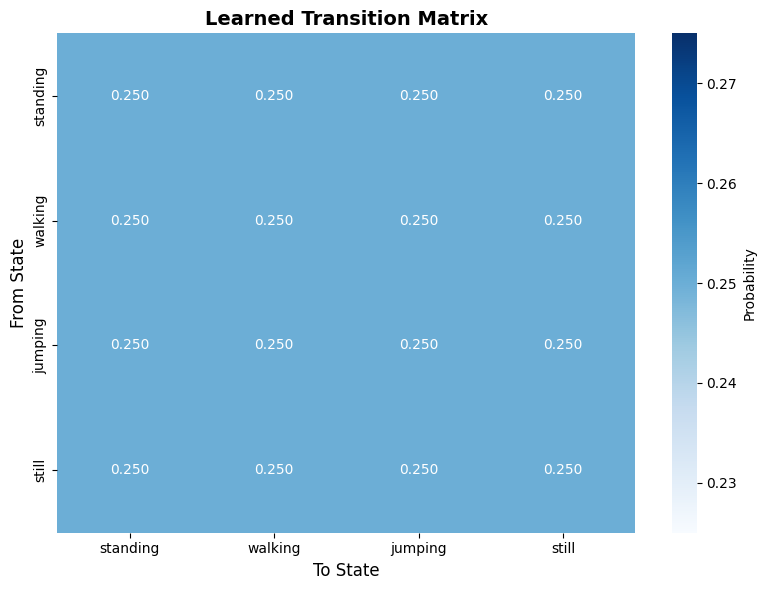

In [20]:
if hmm_model:
    hmm_model.visualize_transition_matrix()
else:
    print("No model to visualize.")

## 6. Model Evaluation

Evaluate the model on unseen test data and calculate performance metrics.

Evaluating model on test data...

Overall Accuracy: 0.257
Mean Log Probability: -1.140

=== Evaluation Results Table ===
  State (Activity)  Number of Samples Sensitivity Specificity
0         standing                 45       1.000       0.631
1          walking                 47       0.000       0.727
2          jumping                 35       0.000       1.000
3            still                 48       0.000       0.630
4          Overall                175           -       0.257


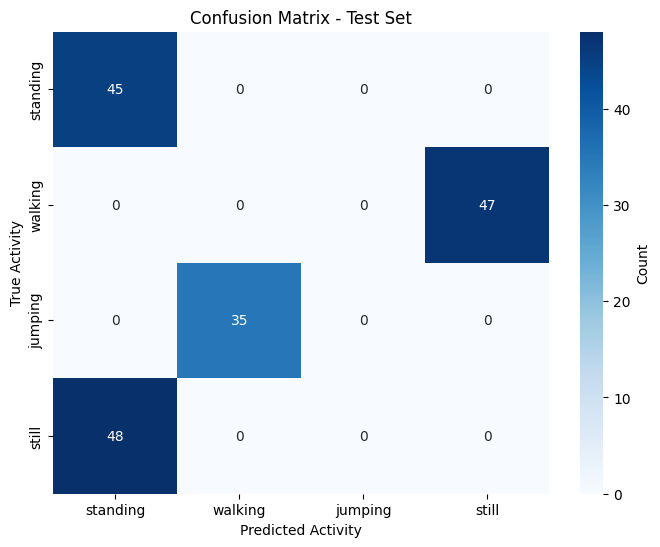


=== Detailed Classification Report ===
              precision    recall  f1-score   support

     jumping       0.00      0.00      0.00        35
    standing       0.48      1.00      0.65        45
       still       0.00      0.00      0.00        48
     walking       0.00      0.00      0.00        47

    accuracy                           0.26       175
   macro avg       0.12      0.25      0.16       175
weighted avg       0.12      0.26      0.17       175



In [21]:
if hmm_model and not test_df.empty:
    print("Evaluating model on test data...")
    metrics = hmm_model.evaluate(test_df)

    print(f"\nOverall Accuracy: {metrics['overall_accuracy']:.3f}")
    print(f"Mean Log Probability: {metrics['mean_log_probability']:.3f}")

    # Table
    eval_table = create_evaluation_table(metrics, hmm_model.activities)
    print("\n=== Evaluation Results Table ===")
    print(eval_table.round(3))

    # Predictions
    predicted_states, log_probs = hmm_model.predict(test_df)
    true_states = test_df['activity'].map(hmm_model.activity_to_state).values
    predicted_activities = [hmm_model.state_to_activity[state] for state in predicted_states]
    true_activities = test_df['activity'].values  # Already acts

    # Confusion matrix
    cm = confusion_matrix(true_activities, predicted_activities, labels=hmm_model.activities)
    cm_df = pd.DataFrame(cm, index=hmm_model.activities, columns=hmm_model.activities)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Activity')
    plt.ylabel('True Activity')
    plt.show()

    print("\n=== Detailed Classification Report ===")
    print(classification_report(true_activities, predicted_activities))
else:
    print("Skipping evaluation - no model or test data.")

### Visualize Predictions


Visualizing predictions for sample: jumping_10


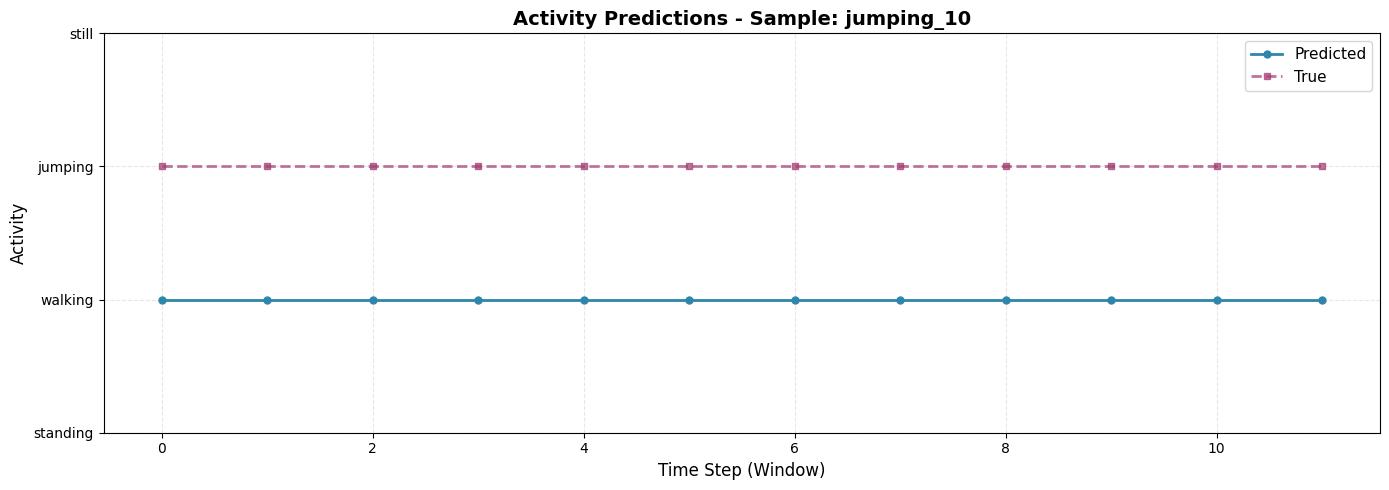

Sample accuracy: 0.000 (0/12 correct)

Visualizing predictions for sample: jumping_11


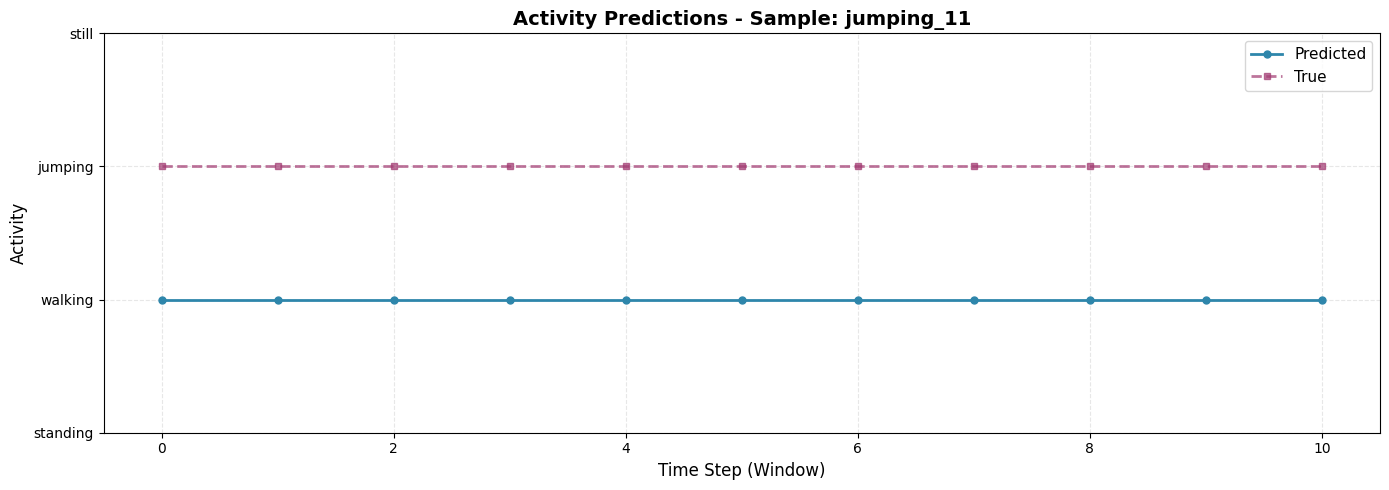

Sample accuracy: 0.000 (0/11 correct)

Visualizing predictions for sample: jumping_12


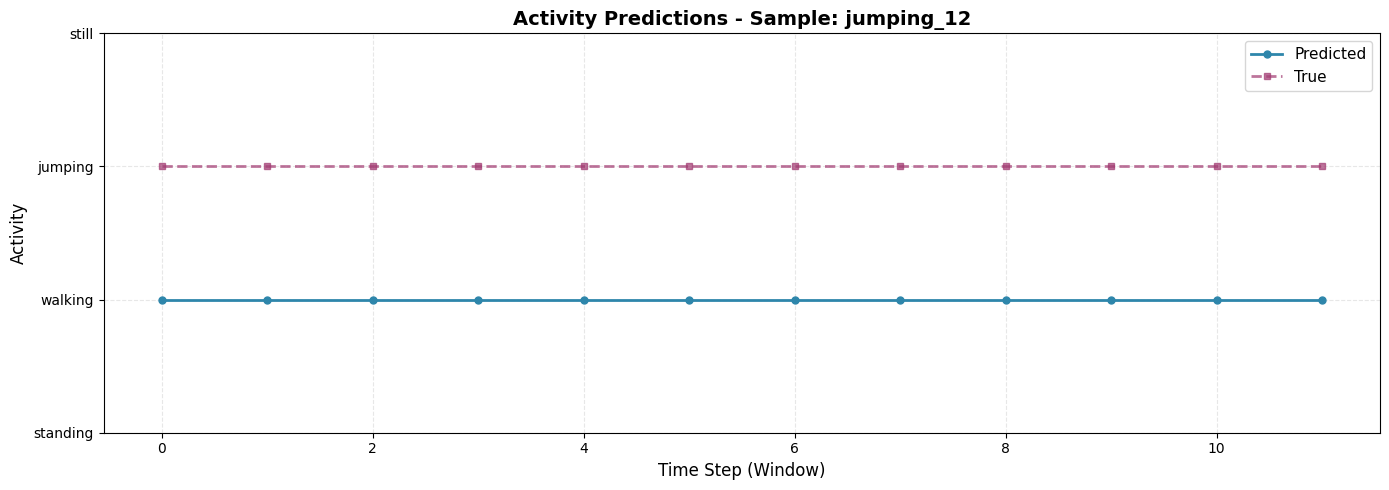

Sample accuracy: 0.000 (0/12 correct)

Visualizing predictions for sample: standing_10


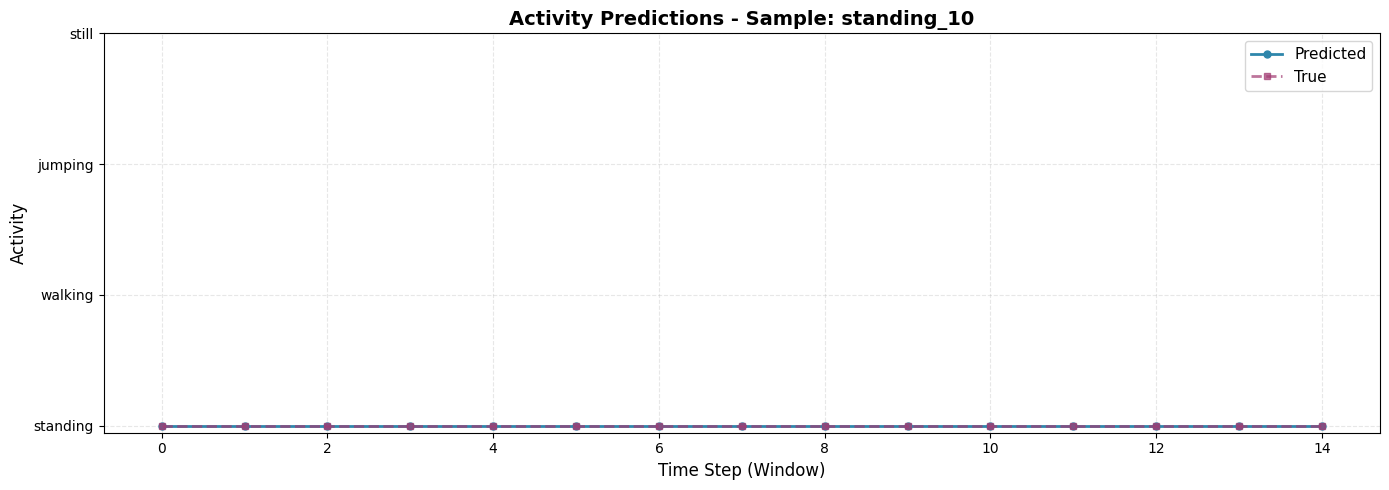

Sample accuracy: 1.000 (15/15 correct)


In [22]:
# Visualize predictions for a few test samples
if hmm_model:
    test_sample_ids = test_df['sample_id'].unique()[:4]
    for sample_id in test_sample_ids:
        print(f"\nVisualizing predictions for sample: {sample_id}")
        hmm_model.visualize_predictions(test_df, sample_id=sample_id)
else:
    print("No model for predictions.")

## 7. Analysis and Insights

Let's analyze the model performance and extract insights.

In [23]:
if hmm_model:
    # Transitions
    transition_matrix = hmm_model.A
    print("=== Transition Matrix Analysis ===")
    print("\nMost likely transitions (probability > 0.1):")
    for i, from_activity in enumerate(hmm_model.activities):
        for j, to_activity in enumerate(hmm_model.activities):
            prob = transition_matrix[i, j]
            if prob > 0.1:
                print(f"  {from_activity} -> {to_activity}: {prob:.3f}")

    print("\n=== Activity Distinguishability ===")
    for activity in hmm_model.activities:
        precision = metrics.get(f'{activity}_precision', 0)
        recall = metrics.get(f'{activity}_recall', 0)
        f1 = metrics.get(f'{activity}_f1', 0)
        print(f"{activity}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # Features
    if not features_df.empty:
        feature_cols = [col for col in features_df.columns if col not in ['sample_id', 'window_idx', 'activity']]
        feature_importance = {}
        for feature in feature_cols:
            overall_var = features_df[feature].var()
            within_class_var = features_df.groupby('activity')[feature].var().mean()
            if within_class_var > 0:
                importance = overall_var / within_class_var
                feature_importance[feature] = importance

        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        print("\n=== Top 10 Most Discriminative Features ===")
        for i, (feature, importance) in enumerate(sorted_features[:10]):
            print(f"{i+1:2d}. {feature}: {importance:.3f}")
else:
    print("No model for analysis.")

=== Transition Matrix Analysis ===

Most likely transitions (probability > 0.1):
  standing -> standing: 0.250
  standing -> walking: 0.250
  standing -> jumping: 0.250
  standing -> still: 0.250
  walking -> standing: 0.250
  walking -> walking: 0.250
  walking -> jumping: 0.250
  walking -> still: 0.250
  jumping -> standing: 0.250
  jumping -> walking: 0.250
  jumping -> jumping: 0.250
  jumping -> still: 0.250
  still -> standing: 0.250
  still -> walking: 0.250
  still -> jumping: 0.250
  still -> still: 0.250

=== Activity Distinguishability ===
standing: Precision=0.484, Recall=1.000, F1=0.652
walking: Precision=0.000, Recall=0.000, F1=0.000
jumping: Precision=0.000, Recall=0.000, F1=0.000
still: Precision=0.000, Recall=0.000, F1=0.000

=== Top 10 Most Discriminative Features ===
 1. acc_z_std: 19.214
 2. acc_sma: 12.436
 3. spectral_energy: 4.169
 4. acc_z_mean: 3.180
 5. acc_y_std: 2.285
 6. acc_x_mean: 0.960
 7. acc_x_std: 0.911
 8. acc_y_mean: 0.757


## 8. Model Persistence

Save the trained model for future use.

In [24]:
if hmm_model:
    os.makedirs('results', exist_ok=True)
    model_path = 'results/trained_hmm_model.pkl'
    hmm_model.save_model(model_path)

    if 'eval_table' in locals() and not eval_table.empty:
        results_path = 'results/evaluation_results.csv'
        eval_table.to_csv(results_path, index=False)
        print(f"Evaluation results saved to {results_path}")

    if 'metrics' in locals():
        metrics_df = pd.DataFrame([metrics])
        metrics_path = 'results/detailed_metrics.csv'
        metrics_df.to_csv(metrics_path, index=False)
        print(f"Detailed metrics saved to {metrics_path}")
else:
    print("No model to save.")

Model saved to results/trained_hmm_model.pkl
Evaluation results saved to results/evaluation_results.csv
Detailed metrics saved to results/detailed_metrics.csv
